In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import polars as pl

In [2]:
from romae.model import RoMAEForPreTraining, RoMAEForPreTrainingConfig, EncoderConfig, RoMAEBase

import torch
from romae_mallorn.dataset import padd_parquet
from romae_mallorn.dataset import MallornDataset, MallornDatasetwLabel
from romae_mallorn.config import MallornConfig
import polars as pl
from romae.trainer import Trainer, TrainerConfig

from romae.utils import get_drop_path, patchify, load_from_checkpoint, get_encoder_size

import matplotlib.cm as cm
import os

from sklearn.decomposition import PCA
import umap
import tqdm

from romae_mallorn.utils import override_encoder_size


2025-11-25 14:45:11.922178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-25 14:45:11.922215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-25 14:45:11.922908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-25 14:45:11.926567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 14:45:13.677330: W tensorflow/compiler/tf2

In [14]:
from romae.model import _get_attn_mask

def get_interpolmasked(model, values: torch.Tensor, mask: torch.Tensor,
            positions: torch.Tensor, pad_mask=None,
            label=None, *_, **__):
    
    b = values.shape[0]
    npd = model.config.n_pos_dims
    # Convert input to a sequence of tubelets
    
    
    x = patchify(model.config.tubelet_size, values)
    
    
    # Extract all the values that are being masked out
    m_x = x[mask].reshape(b, -1, x.shape[-1])
    m_positions = positions[mask[:, None, ].expand(-1, npd, -1)].reshape(b, npd, -1)
    if pad_mask is not None:
        m_pad_mask = pad_mask[mask].reshape(b, -1)
    
    # Now get all the values that are not masked out
    ## It's still squared because of padding
    x = x[~mask].reshape(b, -1, x.shape[-1])
    
    
    positions = positions[~mask[:, None, ...].expand(-1, npd, -1)].reshape(b, npd, -1)
    if pad_mask is not None:
        pad_mask = pad_mask[~mask].reshape(b, -1)

    # Project into embeddings
    x = model.projection(x)
    
    
    # Add classification token to the beginning of all relevant tensors
    x, positions, pad_mask = model.add_cls(x, positions, pad_mask)

    
    x = model.inpt_pos_dropout(model.encoder_inpt_pos_embedding(x, ~mask))

    attn_mask = _get_attn_mask(x.shape, x.device, pad_mask)

    # Encoder forward pass
    embedd = model.encoder(
        x,
        positions=positions,
        pos_encoding=model.encoder_attn_pos_embedding,
        attn_mask=attn_mask
    )
    
    
    # Project tokens from the encoder dimension to decoder dimension
    embedd_proj = model.encoder_decoder_proj(embedd)
    

    mask_tokens = model.mask_token.expand(b, m_x.shape[1], -1)

    # Apply input positional encodings to our MASK tokens.
    mask_tokens = model.inpt_pos_dropout(
        model.decoder_inpt_pos_embedding(mask_tokens, mask)
    )

    # Append MASK token and positional information
    all_ = torch.cat([embedd_proj, mask_tokens], dim=1)
    positions = torch.cat([positions, m_positions], dim=2)
   
    
    if pad_mask is not None:
        pad_mask = torch.cat([pad_mask, m_pad_mask], dim=1)
    ## Both the unmasked and the masked get half of the padding
    ## So now we have [batchsize, (cls, observed, observed_padding, masked, masked_padding),] ordering
    
    
    # Get our new attention and padding masks
    attn_mask = _get_attn_mask(all_.shape, all_.device, pad_mask)
    
    
    # Decoder forward pass
    
    
    x = model.decoder(
        all_,
        positions=positions,
        pos_encoding=model.decoder_attn_pos_embedding,
        attn_mask=attn_mask
    )

    # Need to double-check this:
    m_x = model.normalize_targets(m_x)
    
    x = x[:, -m_x.shape[-2]:] # This will contain also padded stuff that we don't care about so we will have to mask them later

    

    logits, loss = None, None
    if m_x.shape[1] != 0:
        logits, loss = model.apply_head_loss(x, m_x)

    # We reset the positional embedding caches to avoid
    # inter-loop dependencies in the Trainer, which break torch compile.
    model.reset_pos_cache()

    ## logits: predictions for masked_values
    ## m_x: target/trueval

    ## Could have a single function that also returns embeddings cls etc (see further down)
    
    return logits, m_x

In [4]:
!ls /scratch/gcontard/MALLORN/mallorn_test1_verytiny_pretrain_checkpoint_


checkpoint-5800  checkpoint-6000  checkpoint-6200  checkpoint-6400


In [5]:

config = MallornConfig()
config.model_size="very-tiny"
encoder_args = override_encoder_size(config.model_size)
decoder_args = {
                    "d_model": encoder_args['d_model'],
                    "nhead": 3,
                    "depth": 2 
                }
model_config = RoMAEForPreTrainingConfig(
    encoder_config=EncoderConfig(**encoder_args),
    decoder_config=EncoderConfig(**decoder_args),
    tubelet_size=(1, 1, 1),
    n_channels=2,
    n_pos_dims=2
)


model = RoMAEForPreTraining(model_config)

model = load_from_checkpoint('/scratch/gcontard/MALLORN/mallorn_test1_verytiny_pretrain_checkpoint_/checkpoint-6400/',
                            RoMAEForPreTraining, RoMAEForPreTrainingConfig)

In [6]:

dataparq_ = MallornDataset('/scratch/gcontard/MALLORN/test_mallorn_unsup.parq',
                             mask_ratio = 0.5)

In [7]:
test_dataloader = torch.utils.data.DataLoader(
            dataparq_,
            batch_size=5, #You can make this bigger
            num_workers=1,
            pin_memory=True,
            collate_fn=torch.utils.data.dataloader.default_collate,
            prefetch_factor=2,
            shuffle=True
        )

In [18]:
datal['positions'][0][1][datal['pad_mask'][0]]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

torch.Size([5, 591, 2])
torch.Size([5, 591, 2])


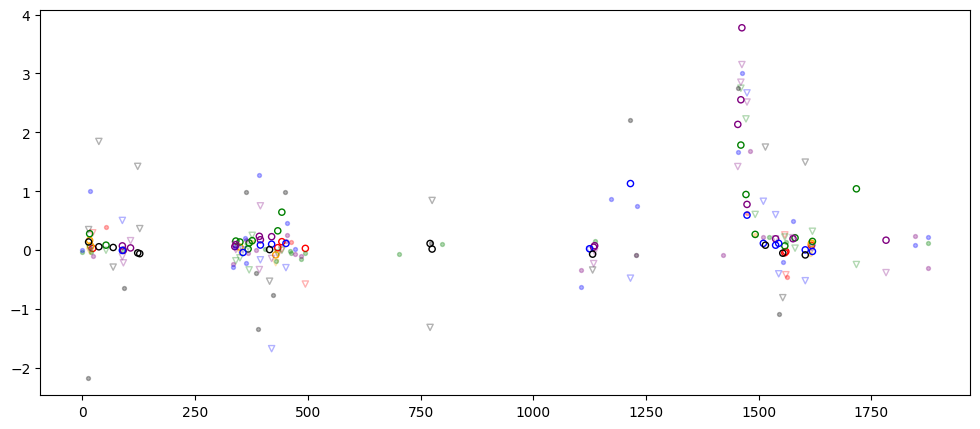

torch.Size([5, 591, 2])
torch.Size([5, 591, 2])


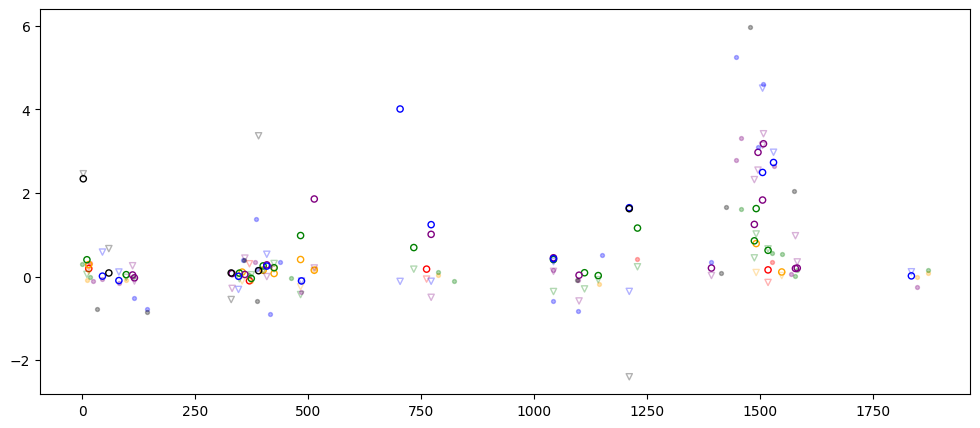

torch.Size([5, 591, 2])
torch.Size([5, 591, 2])


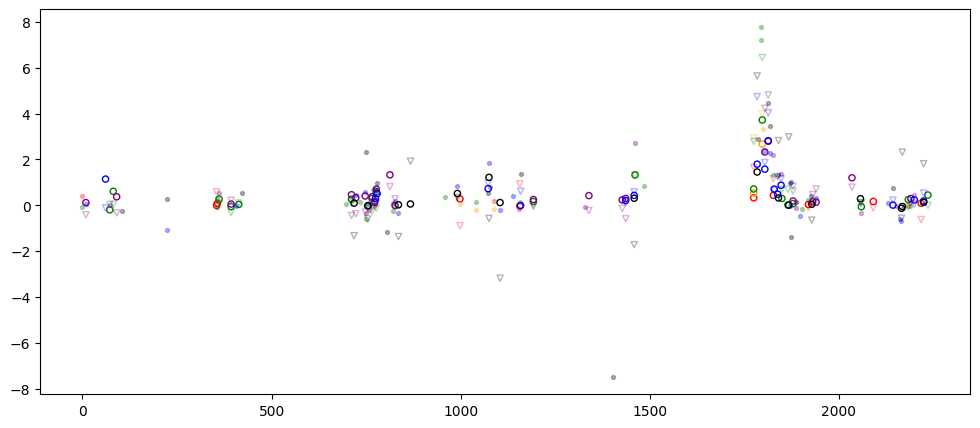

In [20]:
colors = ['r', 'orange', 'g', 'purple', 'b', 'k']


for datal in test_dataloader:
    for idx in [0,1,2]: ## change this if you want to plot more examples (it's not very elegant, I should make a code that uses parquet + idx...)
        
        plt.figure(figsize=(12,5))
        
        logits , m_x = get_interpolmasked(model, datal['values'], datal['mask'],
                datal['positions'], datal['pad_mask'])
        print(logits.shape)
        print(m_x.shape)
        for i in range(6): #eladata[idx]['values'].shape[0]):

            ## Plotting observed values
            mask = (datal['positions'][idx][0]==i) & (~datal['pad_mask'][idx]) &  (~datal['mask'][idx])
            plt.scatter(datal['positions'][idx][1][mask], datal['values'][idx][mask,0,:,:].flatten(), c=colors[i], s=8, alpha=.3)

            ## Masked true values are plotted as triangles
            mask = (datal['positions'][idx][0]==i) & (~datal['pad_mask'][idx]) &  (datal['mask'][idx])
            
            plt.scatter(datal['positions'][idx][1][mask], datal['values'][idx][mask,0,:,:].flatten(), marker='v',
                         facecolors='None', edgecolors=colors[i], s=20, alpha=.3)
        
                        ## Get a mask for predicted values of the current (i) band + of all mask values that are not padded
            mask_band = (datal['positions'][idx][0][datal['mask'][idx]] == i) & (~datal['pad_mask'][idx][datal['mask'][idx]]) 
            
            ## Predicted values are plotted as bigger circles
            plt.scatter(datal['positions'][idx][1][mask], logits[idx,mask_band, 0].flatten().detach(), facecolors='None',
                        edgecolors=colors[i], s=20, alpha=1)
        
        plt.show()
    break
    

In [9]:
from romae.model import _get_attn_mask

def get_embed_decodeencode(model, values: torch.Tensor, mask: torch.Tensor,
            positions: torch.Tensor, pad_mask=None,
            label=None, *_, **__):

    ## For the embed analysis, we shoul not have masked values but this code should work anw
    
    b = values.shape[0]
    npd = model.config.n_pos_dims
    # Convert input to a sequence of tubelets
    
    x = patchify(model.config.tubelet_size, values)
    
    # Extract all the values that are being masked out
    m_x = x[mask].reshape(b, -1, x.shape[-1])
    m_positions = positions[mask[:, None, ].expand(-1, npd, -1)].reshape(b, npd, -1)
    if pad_mask is not None:
        m_pad_mask = pad_mask[mask].reshape(b, -1)
    
    
    # Now get all the values that are not masked out
    
    x = x[~mask].reshape(b, -1, x.shape[-1])
    # print("Shape of the unmasked values")
    # print(x.shape)
    positions = positions[~mask[:, None, ...].expand(-1, npd, -1)].reshape(b, npd, -1)
    if pad_mask is not None:
        pad_mask = pad_mask[~mask].reshape(b, -1)

    # Project into embeddings
    x = model.projection(x)
    
    
    # Add classification token to the beginning of all relevant tensors
    x, positions, pad_mask = model.add_cls(x, positions, pad_mask)

    
    
    x = model.inpt_pos_dropout(model.encoder_inpt_pos_embedding(x, ~mask))

    attn_mask = _get_attn_mask(x.shape, x.device, pad_mask)

    # Encoder forward pass
    embedd = model.encoder(
        x,
        positions=positions,
        pos_encoding=model.encoder_attn_pos_embedding,
        attn_mask=attn_mask
    )
    
    
    # Project tokens from the encoder dimension to decoder dimension
    # (I did this when I had this mismatch between encoder and decoder dimensions. By default otherwise
    # I work on the encoder embeddings, but since the decoder is only 2 layers deep, we could also go further down in the decoder
    # Or we could have a encod/decode with compression then larger dimension (Not relevant necessarily for MALLORN but for
    # that project on the embeddings/unsupervised setting
    
    embedd_proj = model.encoder_decoder_proj(embedd)
    
    

    
    model.reset_pos_cache()

    ## those will contain padding
    # The first is the CLS if there is a CLS token used.
    
    return embedd, embedd_proj

In [18]:
## Get embeddings

def get_embeddings_datasetmodel(dataset, model, size_token=20, size_decod=20, max_examples=10000, device='cuda'):
    
    subset_dataloader = torch.utils.data.DataLoader(
                dataset,
                batch_size=32,
                num_workers=1,
                pin_memory=True,
                collate_fn=torch.utils.data.dataloader.default_collate,
                prefetch_factor=2,
                shuffle=True
            )
    
    emb_enco =  [] ## Not ideal memory wise? check polar. This only keeps the embedding not padded
    emb_deco = []
    #emb_deco, labels_te = np.zeros((0,393, 180)),np.zeros((0,390, 180)), []
    cls_token_enco = np.zeros((0,size_token))
    cls_token_deco = np.zeros((0, size_decod))
    mean_embenco = np.zeros((0,size_token))
    mean_embdeco = np.zeros((0,size_decod))

    labels = []
    #pad_mask = np.zeros((0,393))
    model.eval()

    ## Will also compute the mean of the embed_encod
    
    for datal in tqdm.tqdm(subset_dataloader):
        #print('a')
        val, mask, pos, padmask = datal['values'].to(device), datal['mask'].to(device), datal['positions'].to(device), datal['pad_mask'].to(device)
        encod_emb_tor, decod_emb_tor = get_embed_decodeencode(model, val,mask,pos,padmask )
        
        # print(encod_emb_tor.shape) # encodersize
        # print(decod_emb_tor.shape)  # decoder size
        # print(padmask.shape)
        
        del val, mask, pos, padmask

        # Extracting the CLS
        cls_token_enco = np.vstack([cls_token_enco, encod_emb_tor.detach().cpu().numpy()[:,0,:]])
        cls_token_deco = np.vstack([cls_token_deco, decod_emb_tor.detach().cpu().numpy()[:,0,:]])

        # Now working on the embeddings of the values + padd
        encod_emb = encod_emb_tor.detach().cpu().numpy()[:,1:,:]
        decod_emb = decod_emb_tor.detach().cpu().numpy()[:,1:,:]
        padmask = np.array(datal['pad_mask'].numpy(),dtype=bool)
        
        for i in range(datal['values'].shape[0]): #over the batch
            # Remove paddings
            emb_enco.append(encod_emb[i][~padmask[i]])
        
            mean_embenco = np.vstack([np.mean(emb_enco[-1], axis=0), mean_embenco]) #/n_nopad[:, None]

            # remove paddings
            emb_deco.append(decod_emb[i][~padmask[i]])
        
            mean_embdeco = np.vstack([np.mean(emb_deco[-1], axis=0), mean_embdeco]) #/n_nopad[:, None]


        
        
        labels += datal['label']
        
        torch.cuda.empty_cache()

        if len(labels)>max_examples: # This when I work with elasticc 
            print("Enough examples")
            break
    ## We also store all the individual embeddings to see the trajectory of embeddings in the space
    ## as a function of time or something (which I don't do for now)

    # emb_enco : all individual embeddings of each observation of each light-curves from encoder
    # cls_token_enco :  all CLS embedding/token at encoder level for each light-curves
    # mean_embenco : mean of the individual embeddings for each light-curves, from encoder

    # and same for decoder; Can be removed  if working only at the encoder-end 
    return {"emb_encod": emb_enco, "cls_enco": cls_token_enco, "mean_embed_enco": mean_embenco, 
            "emb_decod": emb_deco, "cls_deco": cls_token_deco, "mean_embed_deco": mean_embdeco, "labels": labels}

In [20]:

dataparq_ = MallornDatasetwLabel('/scratch/gcontard/MALLORN/train_mallorn_supervised.parq',
                             mask_ratio = 0.0) 
## We don't want to mask here ALTHOUGH the stability of the CLS as a function of masking is on my list of things to check...

device='cuda'

In [21]:

config = MallornConfig()
config.model_size="very-tiny"
encoder_args = override_encoder_size(config.model_size)
decoder_args = {
                    "d_model": encoder_args['d_model'],
                    "nhead": 3,
                    "depth": 2 ## I guess this is arbitrary? We could have it at = 1? 
                }
model_config = RoMAEForPreTrainingConfig(
    encoder_config=EncoderConfig(**encoder_args),
    decoder_config=EncoderConfig(**decoder_args),
    tubelet_size=(1, 1, 1),
    n_channels=2,
    n_pos_dims=2
)

model = RoMAEForPreTraining(model_config)

model = load_from_checkpoint('/scratch/gcontard/MALLORN/mallorn_test1_verytiny_pretrain_checkpoint_/checkpoint-6400/',
                            RoMAEForPreTraining, RoMAEForPreTrainingConfig)
model = model.to(device)
all_emb = get_embeddings_datasetmodel(dataparq_, model, size_token=encoder_args["d_model"], size_decod=decoder_args["d_model"],
                                      max_examples=50000)

100%|██████████| 77/77 [00:11<00:00,  6.52it/s]


In [22]:
uniq_lab = np.unique(all_emb['labels'])
uniq_lab

array([0, 1])

In [ ]:
## Checked with PCA, doesnt look like it separates too much...

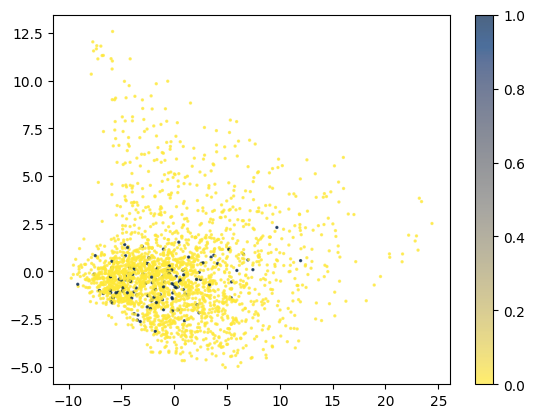

In [28]:
## 
pca_cls = PCA(n_components=5).fit(all_emb['cls_enco'])
cls_pca = pca_cls.transform(all_emb['cls_enco'])
#cls_agn  = pca_cls.transform(clagn_emb_tde['cls_emb'])
plt.figure()
plt.scatter(cls_pca[:,0], cls_pca[:,1], s=2, c=all_emb['labels'],cmap=cm.cividis_r, rasterized=True, alpha=.7)
# plt.xscale('log')
plt.colorbar()
# plt.yscale('log')

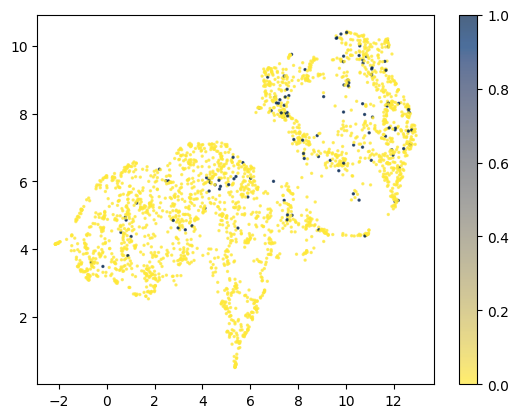

In [29]:
## With UMAP
pca_cls = umap.UMAP().fit(all_emb['cls_enco'])
cls_pca = pca_cls.transform(all_emb['cls_enco'])
#cls_agn  = pca_cls.transform(clagn_emb_tde['cls_emb'])
plt.figure()
plt.scatter(cls_pca[:,0], cls_pca[:,1], s=2, c=all_emb['labels'], cmap=cm.cividis_r, rasterized=True, alpha=.7)
# plt.xscale('log')
plt.colorbar()
# plt.yscale('log')